# Clustering con K-Means sobre dataset de Work-Lfe Balance

## Laboratorio 2022 - Tarea 4

### Grupo 27

Alexis Baladón, CI: 5.574.612-4

Ignacio Viscardi, CI: 5.066.666-2

Rafael Castelli, CI: 5.079.391-2

## Requisitos para reproducción de algoritmo

Para correr el presente notebook se deberán instalar las siguientes dependencias. Queda un script para su instalación automática.

In [ ]:
!pip install -r requirements.txt

## 1. Descripción del problema

En el año 2022 fueron extraídos y compilados datos de diversas ciudades del mundo con el fin de calificarlas de acuerdo a su nivel de balance entre vida y trabajo. En este informe el conjunto de datos Work-Life Balance in Cities será estudiado con el fin de distinguir agrupaciones entre las distintas ciudades haciendo uso de métodos no supervisados, particularmente implementando el algoritmo K-means y evaluando sus resultados de forma cuantitativa (Estudiando su función de costo e índice silhouette) y mediante visualización de los datos en dimensiones reducidas (utilizando PCA).

## 2. Decisiones de diseño

La finalidad de esta sección consiste en introducir las principales decisiones de diseño tomadas para esta implementación de K-means.

### 2.1 Preprocesado

Primeramente, se toma la decisión de eliminar el nombre de la ciudad y país del conjunto de datos. Esto se hace debido a que ambos son atributos categóricos, por lo que sería necesaria una técnica como one-hot encoding para trabajar sobre ellos, pudiendo tener efectos indeseados al calcular la distancia euclídea (especialmente al normalizar los datos) debido a la maldición de la dimensionalidad. Más aún, no fueron considerados relevantes para medir el work-life balance.
Por otra parte, también se eliminó la columna 2021 y 2022 ya que estos atributos no parecen ser relevantes para el problema en cuestión, además de ser identificadores únicos de cada tupla.

En la seccion 3 (Experimentación) se mencionarán, cuando se considere adecuado, otras variables que fueron eliminadas del conjunto de datos para realizar los experimentos pertinentes.

### 2.2 Metaparámetros

Como metaparámetros del algoritmo se utilizan los siguientes atributos:

- Conjunto de datos: Se requiere el conjunto de datos a agrupar con k-means en un DataFrame de Pandas. 
- Número de clusters (opcional): Es posible asignar un número de clusters. Por defecto este valor es 2 dado el análisis realizado en posteriores secciones.
- Epsilon para condición de parada (opcional): Se utiliza un epsivalor lon par como condición de parada del algoritmo. Si la distancia entre los centroides de una iteración y la siguiente es menor que un epsilon dado (utilizando la norma 2), entonces el algoritmo se detiene, retornando los centroides calculados hasta el momento. El epsilon por defecto es 0.001.
- Semilla (opcional): Para Se utiliza para que los experimentos sean reproducibles, dado que el algoritmo es estocastico. El valor por defecto es 27.

### 2.3 Método de inicialización
Se consideraron 2 métodos de inicialización para los centroides del algoritmo K-means. 
Uno de los métodos realiza una selección aleatoria de K elementos del espacio de posibles elementos (se considera que un elemento x esta en el espacio de posibles elementos si para cada coordenada su valor es menor o igual que el maximo valor, en valor absoluto, que puede tomar dicha coordenada en el dataset provisto).

El otro método de inicialización considerado consiste en tomar k elementos del dataset (al azar) como centroides iniciales. Este método debería tener mejores propiedades de convergencia y ser menos propenso a dejar clusters vacios durante la ejecución.

### 2.4 Manejo de cluster vacios en K-Means

Dado que el algoritmo k-means presentado en el curso no contempla el caso de generar cluster vacios, fue necesario agregar cierta logica al algoritmo de modo que esto no ocurra.

En particular, en cada iteración del algoritmo, luego de asignar los elementos a los clusters, se verifica si existen clusters sin elementos asignados. En caso afirmativo, se reasignarán los centroides de estos clusters. Este proceso se repetirá hasta que el problema se solvente.

Notese que la técnica utilizada para reasignar los centroides consistió en tomar el elemento del dataset mas cercano al centroide del cluster vacio y asignar dicho elemento como nuevo centrodide del cluster. De esta manera nos aseguramnos de que el cluster contenga al menos un elemento.

## 3 Experimentos

Para la experimentación, se considera el conjunto de datos sin normalizar y luego normalizado, con el fin de contrastar el efecto que la normalización puede tener en el algoritmo kmeans. Dado que la mayoría de los datos están en una escala de 0 a 100, y aquellos que no están, tampoco tienen escalas muy distintas, parece razonable empezar sin normalizar los datos, para evitar perturbaciones a la varianza y los clusters producidos.

En lo que sigue, se distinguen 3 casos del conjunto de datos: *original_df* corresponde al conjunto de datos tal cual se carga directamente del CSV, sin realizarle ningún preprocesado. Dicho objeto se utiliza para encontrar a Montevideo (y potencialmente otras ciudades) dentro de los datos. *minimal_preprocess_df* corresponde al conjunto de datos donde el único preprocesado que se hace es eliminar las columnas nombradas en la sección 2.1 y eventualmente la normalización de los datos. Por último *df* corresponde al dataset con donde se eliminan todas las columnas que se consideraron irrelevantes dado el análisis del dataset.

Vale la pena aclarar que para los experimentos realizados en los que se utiliza el método del codo y silhouette, se tomaron los datos a partir del promedio de los resultados obtenidos al correr los experimentos con distintas semillas las cuales son utilizadas por el generador de números aleatorios, debido a que k-means es una técnica estocástica.

### 3.1 Sin normalizacion

#### 3.1.1 Prerequisitos:

Antes de correr todos los test que siguen, es necesario correr esta celda de código con el fin de cargar algunas variables que serán reutilizadas a lo largo de la experimentación.

In [2]:
import preprocessing
import constants
import os
from test import Test

original_df = preprocessing.load_csv()
minimal_preprocess_df = preprocessing.minimal_preprocess(original_df)
df = preprocessing.preprocess(original_df, shouldNormalize=False)
test = Test()
k_values = list(range(1, constants.MAX_K_PLUS_1))

#### 3.1.2 Análisis de valores propios

Para tener una idea del número de dimensiones relevantes y por panto una potencial pista del número de columnas que no lo son de las cuales se puede prescindir, se grafican los valores propios para ver sus magnitudes y compararlas. Se muestran a continuación sus valores en base a una escala lineal.

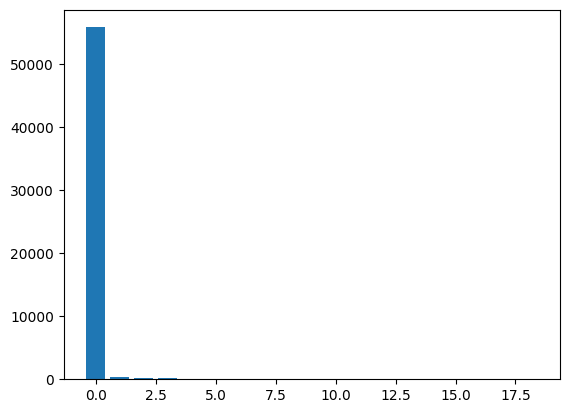

In [3]:
test.PCA_eigen_values(minimal_preprocess_df, scale="linear", drop_first=False)

Claramente, la escala lineal muestra que existe un valor propio que domina ámpliamente a los demás. Para poder apreciar mejor el comportamiento de los demás valores propios, se repite el experimento sin considerar el primero. Como adjunto se grafican los valores propios en escala logaritmica.

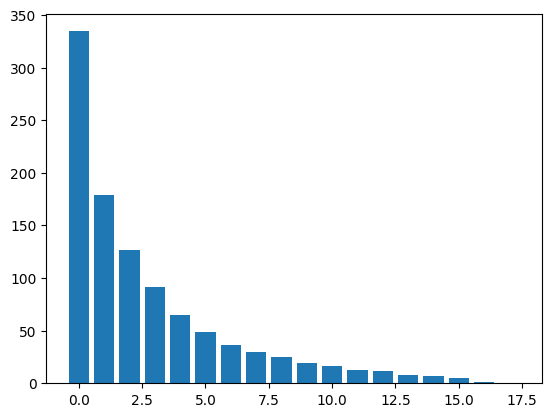

In [4]:
test.PCA_eigen_values(minimal_preprocess_df, scale="linear", drop_first=True)

Es clara la existencia de un valor propio ampliamente dominante sobre el resto, además de que el segundo valor propio más grande es aproximadamente 2 veces el tercer mayor valor. Luego, se concluye que existe lugar para descartar algunas columnas (se visualiza mejor al analizar la matríz de covarianza), y es claro que se deben conservar al menos 2 o 3 dimensiones. Luego, empieza a ser discutible donde se puede realizar el punto de corte para dejar de descartar dimensiones.

Se recuerda que dichas dimensiones (las dadas por PCA) no se corresponden directamente con las dimensiones del conjunto de datos original pero puede dar una idea sobre la importancia relativa de las distintas dimensiones.

No obstante, en este caso no resulta extremadamente evidente las conclusiones que se puedan sacar.

### 3.1.3 Estudio de covarianza

Para continuar con la selección de atributos, se analiza la covarianza entre los distintos atributos. Particularmente, ya que es de interés analizar la interdependencia de los distintos atributos y no tanto si un atributo influye positivamente o negativamente sobre otro, se toma el valor absoluto de la covarianza para facilitar el análisis visual.


##### 3.1.3.1. Matriz de covarianza

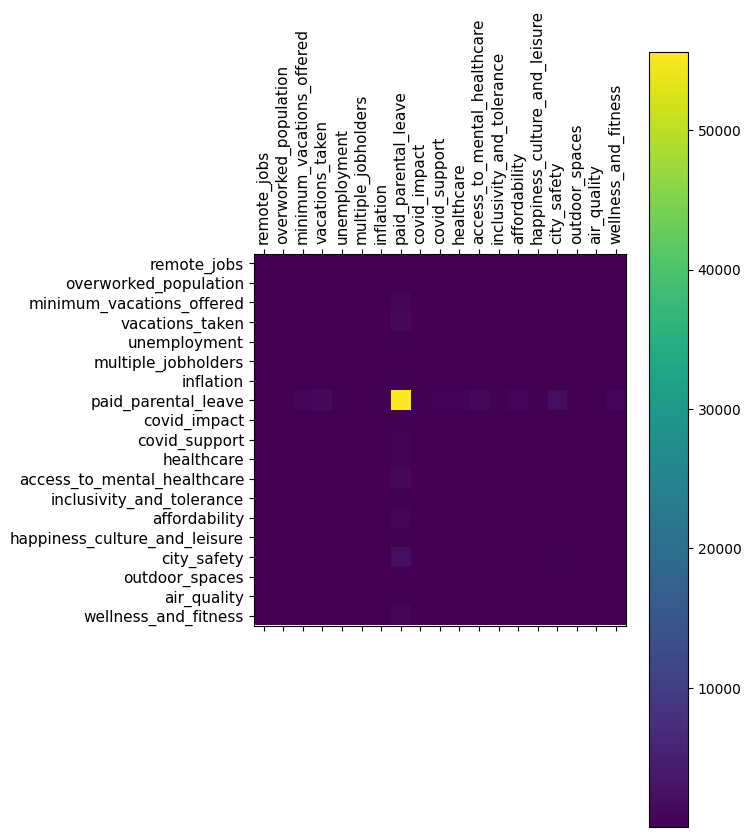

In [5]:
test.abs_covariance_matrix(minimal_preprocess_df)

Como ilustra la imagen anterior, las escalas de la matriz de covarianza no facilitan el análisis visual de la situación. Por esto, se utiliza el valor absoluto de la correlación.

##### 3.1.3.2. Matriz de correlación en dataset minimo

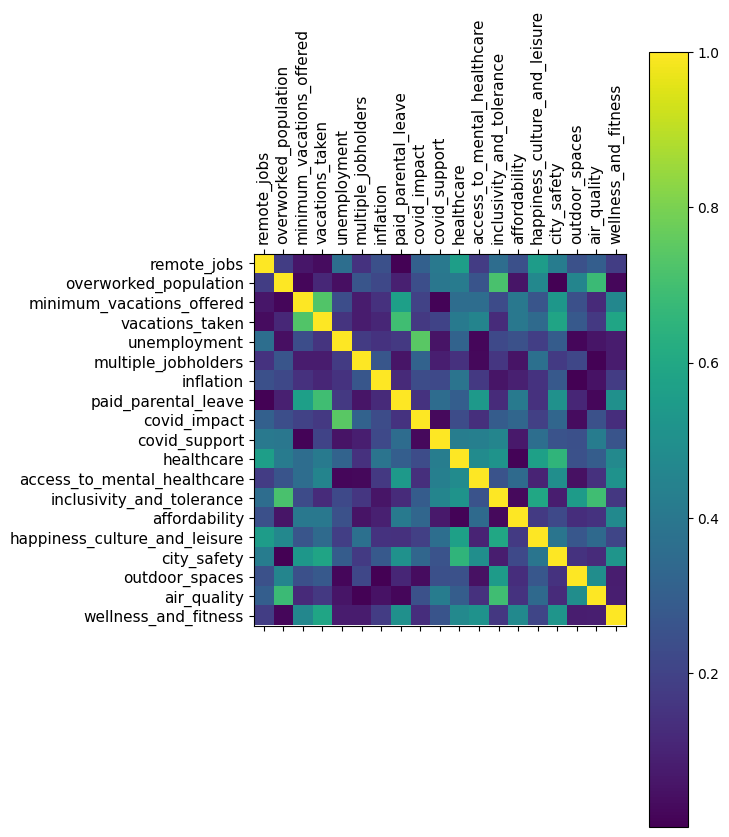

In [6]:
test.abs_correlation_matrix(minimal_preprocess_df)

Gráficamente la situación mejora, ahora se distinguen atributos que están claramente correlacionados, como "minimun_vacations_offered" y "vacations_taken". Algunas de estas correlaciones parecen muy intuitivas (como la anterior) y otras pueden ser discutibles.

A continuación se presenta la matriz de correlación absoluta que se obtiene luego de la selección de atributos. Luego se presenta una herramienta utilizada para la selección de atributos y por último se da una explicación de la selección realizada. Como estrategia general, dados dos atributos A1 y A2, se intenta eliminar uno de los dos si ambos están muy correlacionados (positiva o negativamente) pues es esperable que no aporten mucha información adicional y removerlos contribuye a reducir la dimensionalidad del dataset y potencialmente mejorar la calidad de las técnicas aplicadas. Notar que en esta estrategia no se consideran correlaciones entre 3 o más atributos conjuntamente.

##### 3.1.3.3. Matriz de correlación en dataset preprocesado

A continuación se realiza el mismo estudio en el conjunto de datos con menor cantidad de columnas

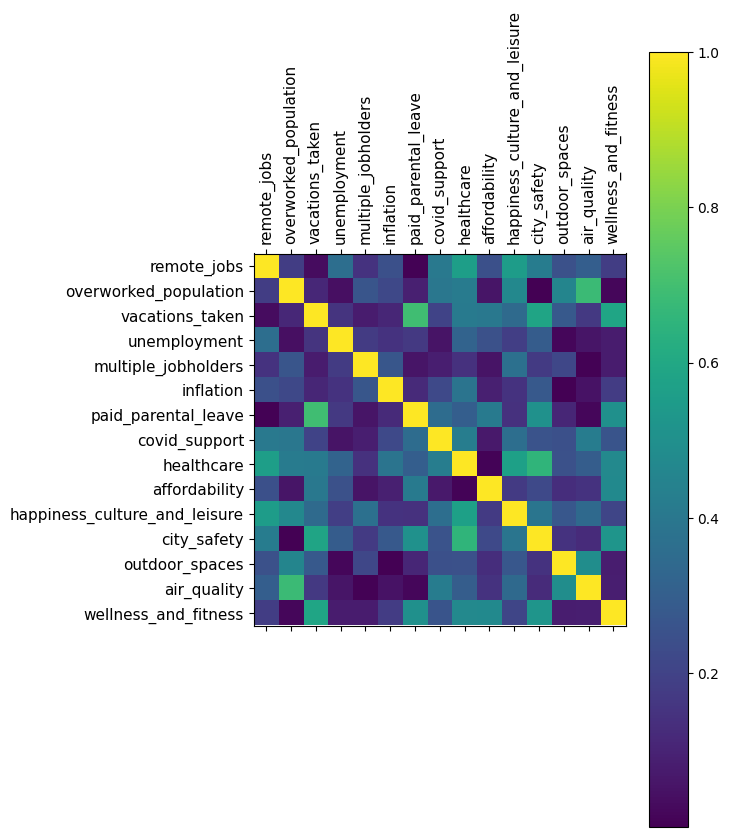

In [7]:
test.abs_correlation_matrix(df)

Como herramienta adicional, se utiliza la misma matriz de correlación absoluta pero filtrada con un punto de corte tal que: si xij > punto de corte entonces xij <- 1 en otro caso xij <- 0.

Esto facilita la visualización de atributos altamente correlacionados, dismunuyendo gradualmente el punto de corte y observando en "orden de importancia" relaciones entre los datos.

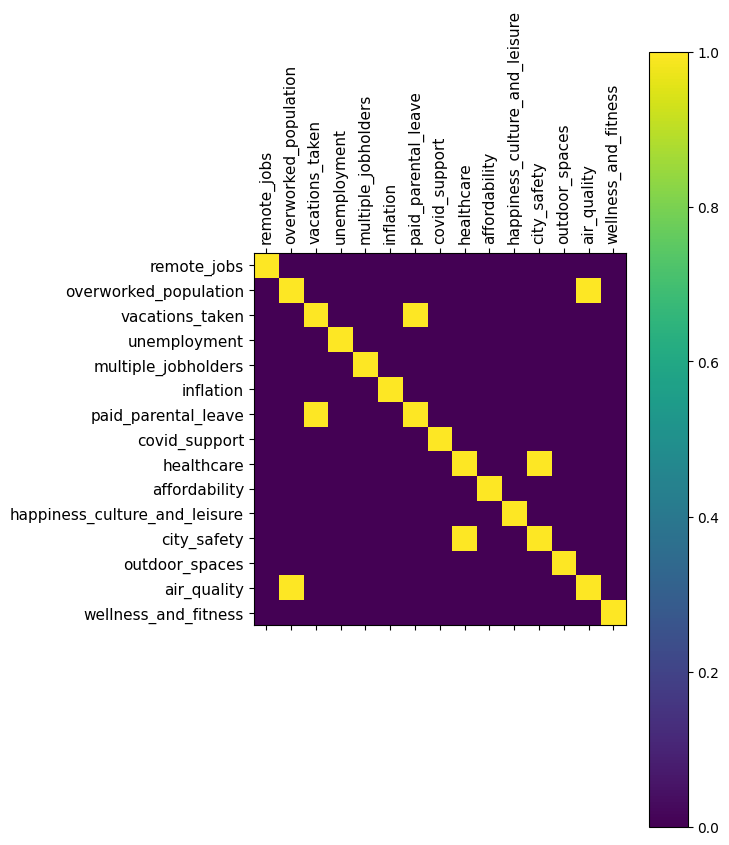

In [8]:
test.cutpoint_abs_correlation_matrix(df, cutpoint=0.60)

Es esperable que los atributos "healthcare" y "access_to_mental_healthcare" estén relacionados. Observando la matriz de covarianza se confirma esta hipótesis. Dado que se puede considerar "mental_healthcare" dentro de "healthcare", se decide eliminar la columna "access_to_mental_healthcare" y quedarse solo con "healthcare".

Por otro lado, parece bastante razonable tener una correlación entre "minimun_vacations_offered" y "vacations_taken". Nuevamente la matriz de covarianza confirma la hipótesis por lo que se puede considerar como "redundante" a una de ambas columnas. Intuitivamente se considera que para el balance entre vida privada y trabajo, es más relevante el numero de vacaciones que efectivamente se toman respecto a las que se ofrecen, por lo que se elimina "minumun_vacations_offered" y se mantiene "vacations_taken".


Utilizando la matriz con el punto de corte 0.7, se observa una fuerte correlación entre "covid_impact" y "unemployment". Como se considera más relevante para el problema presenta los niveles de desempleo y también se puede argumentar (especialemente considerando la correlación entre ambos atributos, que demuestra como dentro de los factores computados dentro de "covid_impact" el desempleo o la economía es de los más ponderados) que "unemployment" es un "atributo más general", de forma análoga como se hizo con "healthcare". Luego, se preserva "unemployment" sobre "covid_impact".
Por último se observa que "inclusivity_and_tolerance" tienen una correlación de más de 0.6 con "overworked_population", lo que puede ser indicio de que uno de los atributos es "redundante". Por otro lado, "inclusivity_and_tolerance" intuitivamente no parece tener mucho que ver (al menos a grandes razgos) con el balance vida-trabajo, mientras que la población que tiene que trabaja de más claramente está relacionada con la temática. En virtud de esto, se elimina la columna "inclusivity_and_tolerance".
Luego de este análisis, se consiguen resultados relativamente claros en el método del codo, así como el análisis del coeficiente de Silhouette y en la visualización por PCA de los clusters y por tanto se decide dejar de eliminar atributos.

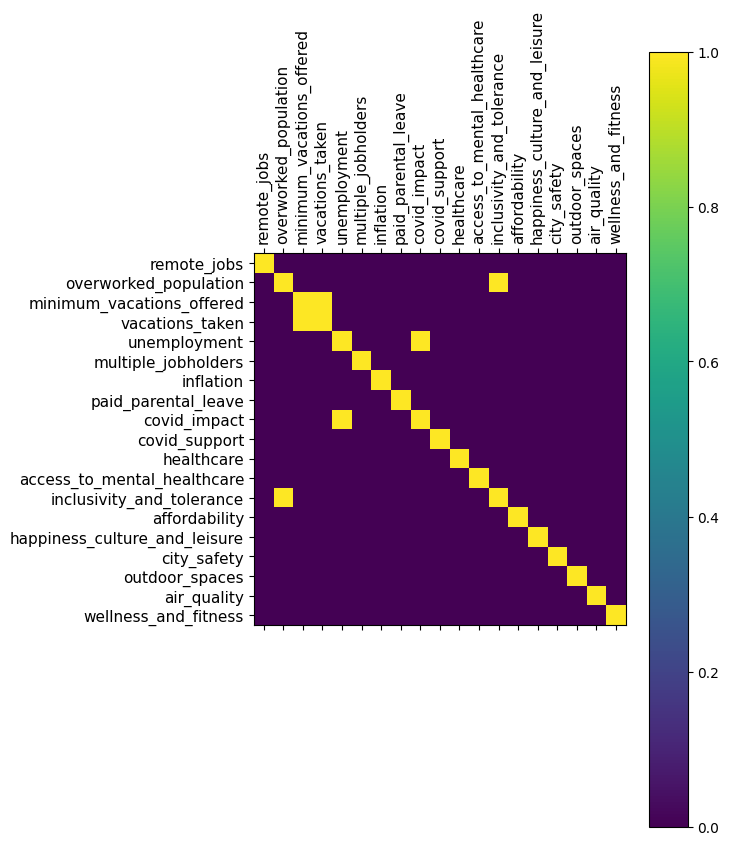

In [9]:
test.cutpoint_abs_correlation_matrix(minimal_preprocess_df, cutpoint=0.70)

#### 3.1.4. Silhouette

A continuación se grafica el coeficiente de Silhouette respecto al número de clusters.

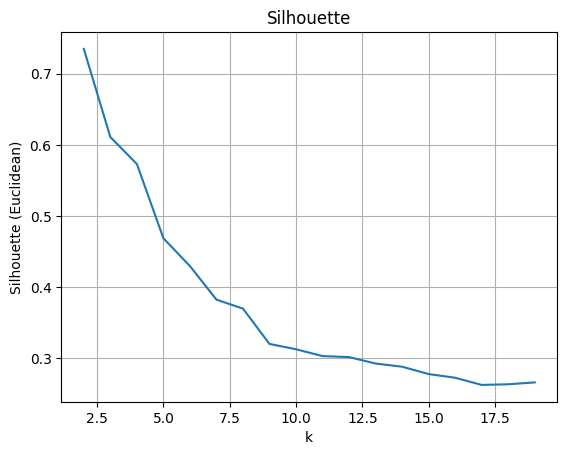

In [10]:
k_values = [x for x in range(2, constants.MAX_K_PLUS_1)]
test.test_silhouette(k_values=k_values, dataset=df, cpu_count=os.cpu_count())

Viendo la gráfica, se desprende que el número óptimo de clusters es 2 dado que alli es donde toma el valor máximo.

#### 3.1.5. Método del codo

Aquí se utiliza el método del codo para intentar determinar el número óptimo de clusters.

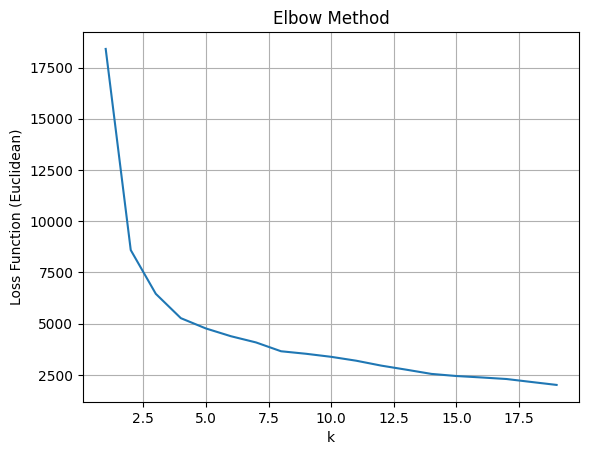

In [11]:
k_values = [x for x in range(1, constants.MAX_K_PLUS_1)]
test.test_elbow_method(dataset=df,k_values=k_values,cpu_count=os.cpu_count())

De la gráfica se desprende que 2 es un posible número de clusters óptimos, coincidiendo con Silhouette. Por otro lado, se puede cuestionar si 4 parece un número razonable de clusters, especialmente cuando se lo grafica utilizando PCA. Como ambos números parecen posibles candidatos, pero 2 es confirmado por ambos métodos, por defecto se concluye que 2 es el número óptimo de clusters. No obstante, gráficamente se puede ver la competividad que tienen 2 y 4 como número óptimo de clusters, e incluso se podría considerar al 3.

#### 3.1.6 PCA

Como ya fue mencionado, PCA logra reducir la dimensionalidad de un espacio con un alto número de de variables haciendo uso de la covarianza entre atributos y minimizando la información perdida.

#### 3.1.6.1 PCA con 2 clusters

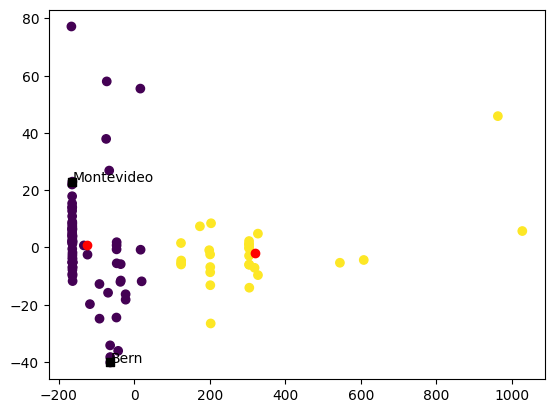

In [12]:
import preprocessing
import constants
from test import Test

original_df = preprocessing.load_csv()
df = preprocessing.preprocess(original_df, shouldNormalize=False)
test = Test()
test.PCA_graph(df,original_df,dimensions=2,number_of_clusters=2)

#### 3.1.6.2 PCA con 4 clusters

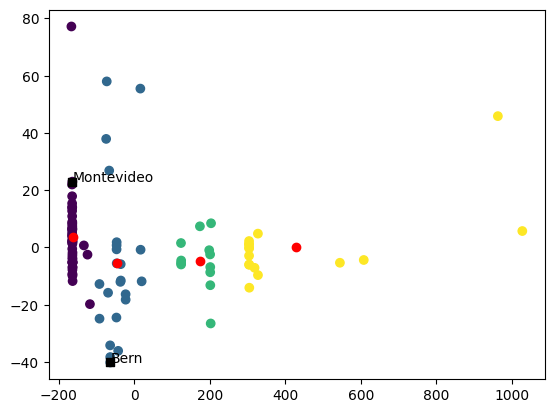

In [13]:
import preprocessing
import constants
from test import Test

original_df = preprocessing.load_csv()
df = preprocessing.preprocess(original_df, shouldNormalize=False)
test = Test()
test.PCA_graph(df,original_df,dimensions=2,number_of_clusters=4)

De los resultados anteriores se puede ver que tanto 2 como 4 clusters constituyen opciones viables, si bien las métricas indican a 2 como el número óptimo de clusters. Probando con otros valores mayores a 4, las agrupaciones dejan de ser intuitivamente correctas.

Entrando en detalle en los resultados, y dado que en el listado Montevideo aparece con un ranking ampliamente desfavorable, se puede inducir a que el cluster al cual pertenece es el cluster de aquellas ciudades con un mal balance entre vida privada y trabajo. Para corroborar la hipótesis, se ubica a Bern (la segunda mejor ciudad en el listado) y aparece en el mismo cluster que Montevideo, lo cual parece ir en contra de la intuición. Considerando los datos con el preprocesado mínimo definido, la situación no cambia. Por su parte, Oslo (la mejor ciudad del listado) queda en el otro cluster.

Esto da a entender que o el número de clusters no es el apropiado (con 4 clusters Bern se posiciona en un cluster distinto a Montevideo) o que el dataset contiene ruido. La segunda conclusión, puede verse apoyada en algunas de las extrañas correlaciones entre algunos de los atributos, como la relación entre "air_quality" y "inclusivity_and_tolerance". Por otro lado, el conjunto de datos tiene algunos datos con valores 0, lo cual parece poco razonable, or ejemplo, segun el dataset se toman 0 vacaciones en Montevideo (ver columna "vacations_taken" en Montevideo).

Para indagar un poco más sobre lo sucedido, se imprimen todas las ciudades (y su ranking según la tabla original) que pertenecen al mismo cluster que Montevideo 

In [14]:
import preprocessing
import constants
import os
import pandas as pd
from test import Test

original_df = preprocessing.load_csv()
minimal_preprocess_df = preprocessing.minimal_preprocess(original_df)
df = preprocessing.preprocess(original_df, shouldNormalize=False)

test = Test()
k_values = list(range(1, constants.MAX_K_PLUS_1))

cities = test.get_cities_in_the_same_cluster(original_df, df, city = "Montevideo", country = "Uruguay", clusters=2)
with pd.option_context('display.max_rows', 100):
    print(cities)

1                 Bern
3               Zurich
5               Geneva
7               Sydney
11           Melbourne
12           Amsterdam
16            Auckland
28                Graz
31             Seattle
32            Portland
34         Minneapolis
35      Salt Lake City
36              Dublin
37              Boston
38       San Francisco
40          Washington
41              Madrid
42               Omaha
43           San Diego
44           Singapore
45              Denver
46      Virginia Beach
47             Raleigh
48          Sacramento
49           Barcelona
51          Des Moines
52            Honolulu
54    Colorado Springs
55               Tampa
56         Kansas City
57           Charlotte
58            New York
59             Atlanta
60           Milwaukee
61              Austin
63          Pittsburgh
64        Jacksonville
65           Nashville
66          Cincinnati
67            Columbus
68             Chicago
69               Miami
70           Baltimore
71        P

El conjunto contiene 72 elementos y corresponde a la gran agrupación de puntos que se encuentra a la derecha de la gráfica de los clusters. Claramente, el conjunto tiene un amplio rango de ciudades en distintas posiciones del ranking y no se puede atribuir al cluster como aquellas ciudades con mal balance entre vida privada y trabajo.

Dada la gran agrupación de puntos, puede ser que normalizar ayude en este caso.

### 3.2 Conjunto de datos normalizado

A continuación se presentarán los mismos expermientos que fueron realizados en la sección 3.1 pero esta vez utilizando el dataset normalizado.

In [15]:
import preprocessing
import constants
import os
from test import Test

original_df = preprocessing.load_csv()
minimal_preprocess_df = preprocessing.minimal_preprocess(original_df)
df = preprocessing.preprocess(original_df, shouldNormalize=True)
test = Test()
k_values = list(range(1, constants.MAX_K_PLUS_1))

#### 3.2.1 Silhouette

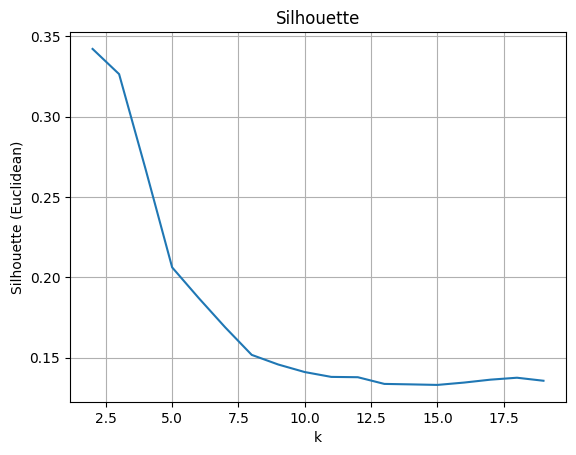

In [16]:
k_values = [x for x in range(2, constants.MAX_K_PLUS_1)]
test.test_silhouette(k_values=k_values, dataset=df, cpu_count=os.cpu_count())

Se puede observar que el resultado es un poco diferente al obtenido en el conjunto de datos sin normalizar. En particular, parece ser que el valor de 3 clusters es más grande que el antes presentado con respecto a 4.

#### 3.2.2 Método del codo

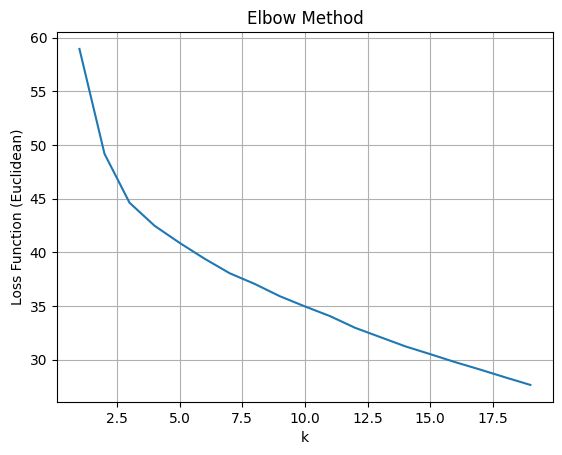

In [17]:
import preprocessing
import constants
import os
from test import Test

original_df = preprocessing.load_csv()
df = preprocessing.preprocess(original_df, shouldNormalize=True)
test = Test()
k_values = [x for x in range(1, constants.MAX_K_PLUS_1)]
test.test_elbow_method(dataset=df,k_values=k_values,cpu_count=os.cpu_count())

Como el coeficiente silhouette parecía indicar, el método del codo confirma la sospecha de que 3 parece ser un nuevo candidato a número de clusters, aunque 2 parece seguir siendo una cantidad ideal.

#### 3.2.33Visualización con PCA

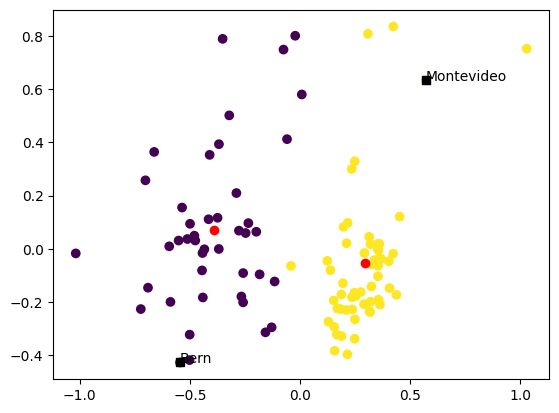

In [18]:
import preprocessing
import constants
from test import Test


original_df = preprocessing.load_csv()
df = preprocessing.preprocess(original_df, shouldNormalize=True)
test = Test()
test.PCA_graph(df,original_df,dimensions=2,number_of_clusters=2)

Analizando estos resultados se ve con claridad que existen puntos que aparentan pertenecer a distintos clusters. En particular, existe un conjunto de datos del lado izquierdo que parece estar altamente relacionado, lo cual el algoritmo logra captar agrupando a todos. Por otro lado, se agrupa en otro cluster a ciudades que también parecen estar relacionadas, aunque además se agrupan datos que parecerían ser ruidosos. Esto aún así parece indicar que el algoritmo logra cumplir con su objetivo, al igual que da a conocer propiedades difíciles de ver a simple vista.

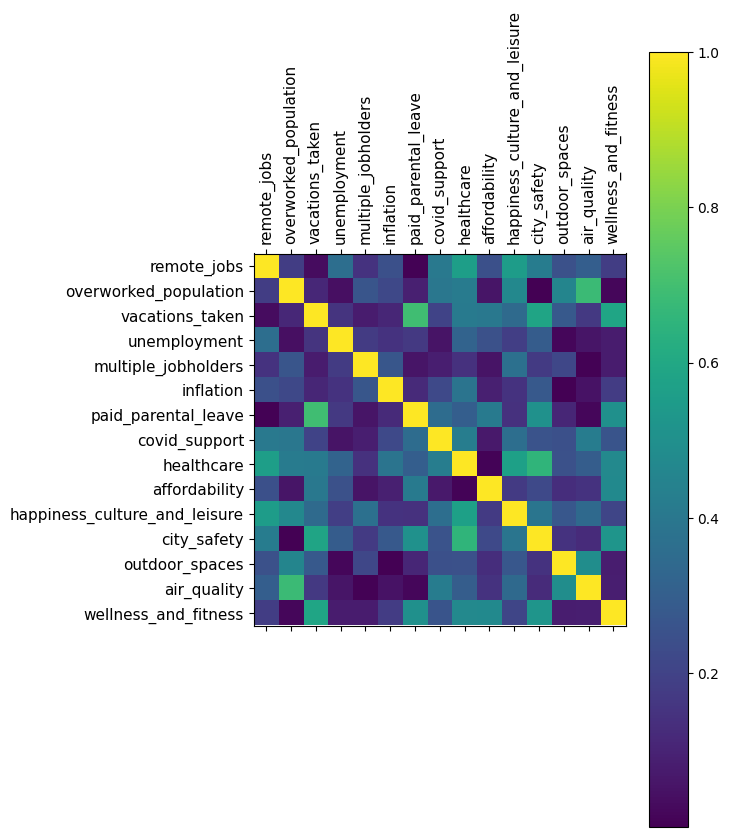

In [19]:
test.abs_correlation_matrix(df)

Los datos aquí mostrados no deberían ser de sorpresa, ya que la matriz de correlación logra identificar los mismos patrones que lograba la antes vista con ligeros cambios.

In [20]:
import preprocessing
import constants
import os
import pandas as pd
from test import Test
from k_means import KMeans

original_df = preprocessing.load_csv()
minimal_preprocess_df = preprocessing.minimal_preprocess(original_df)
df = preprocessing.preprocess(original_df, shouldNormalize=True)

test = Test()
k_values = list(range(1, constants.MAX_K_PLUS_1))

cities = test.get_cities_in_the_same_cluster(original_df, df, city = "Montevideo", country = "Uruguay", clusters=2)
with pd.option_context('display.max_rows', 100):
    print(cities)

31             Seattle
32            Portland
34         Minneapolis
35      Salt Lake City
37              Boston
38       San Francisco
40          Washington
42               Omaha
43           San Diego
45              Denver
46      Virginia Beach
47             Raleigh
48          Sacramento
50              Lisbon
51          Des Moines
52            Honolulu
54    Colorado Springs
55               Tampa
56         Kansas City
57           Charlotte
58            New York
59             Atlanta
60           Milwaukee
61              Austin
63          Pittsburgh
64        Jacksonville
65           Nashville
66          Cincinnati
67            Columbus
68             Chicago
69               Miami
70           Baltimore
71        Philadelphia
72        Indianapolis
73              Tucson
74           Cleveland
75       Oklahoma City
76              Dallas
77         Los Angeles
78             Phoenix
79         San Antonio
80               Tulsa
81             Wichita
82         

Normalizando los datos, se obtienen resultados más razonables respecto a la relación entre los clusters y la posición que se les asigna en el conjunto de datos original. Se intentará además realizar la misma prueba para 3 clusters, lo cual debería mostrar un cambio significativo con respecto a los dato sin escalar.

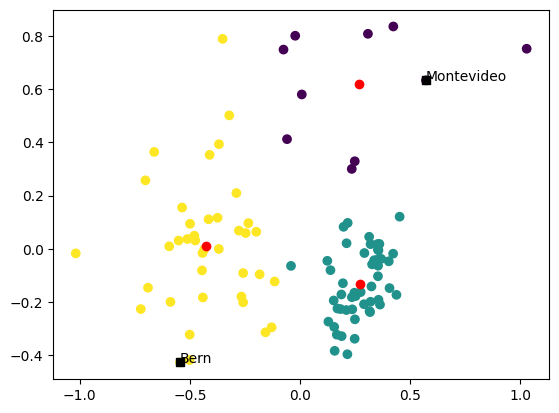

In [21]:
import preprocessing
import constants
from test import Test


original_df = preprocessing.load_csv()
df = preprocessing.preprocess(original_df, shouldNormalize=True)
test = Test()
test.PCA_graph(df,original_df,dimensions=2,number_of_clusters=3)

Luego de visualizar los datos de este modo queda mucho más clara la posibilidad de separar a estas ciudades en un nuevo cluster. Sorprende de todos modos que la visualización bidimensional de la prueba anterior no dejaba tan clara esta posibilidad, probablemente debido a la pérdida de dimensiones originales generada por PCA.

In [22]:
import preprocessing
import constants
import os
import pandas as pd
from test import Test
from k_means import KMeans

original_df = preprocessing.load_csv()
minimal_preprocess_df = preprocessing.minimal_preprocess(original_df)
df = preprocessing.preprocess(original_df, shouldNormalize=True)

test = Test()
k_values = list(range(1, constants.MAX_K_PLUS_1))

cities = test.get_cities_in_the_same_cluster(original_df, df, city = "Montevideo", country = "Uruguay", clusters=3)
with pd.option_context('display.max_rows', 100):
    print(cities)

50          Lisbon
87           Seoul
92       Hong Kong
93      Montevideo
94    Buenos Aires
95         Bangkok
96       Sao Paulo
97    Kuala Lumpur
98           Dubai
99       Cape Town
Name: city, dtype: object


Analizando las ciudades agrupadas en este nuevo cluster, no cabe duda de que la agrupación es altamente congruente con la asignación del ranking realizada originalmente en el conjunto de datos. Se observa que, de 10 ciudades en el cluster, solo 2 de ellas estan fuera de las 10 peores ciudades del dataset. Más aún, una de ellas es de las 15 con peor ranking, y la otra no es mejor que la mejor mitad.

##### 3.3.3.1. PCA 3D

Se analiza adicionalmente la versión tridimensional de PCA, la cual representa los datos con una menor pérdida de información con respecto a la anteriormente mencionada.

In [23]:
import preprocessing
import constants
from test import Test


original_df = preprocessing.load_csv()
df = preprocessing.preprocess(original_df, shouldNormalize=True)
test = Test()

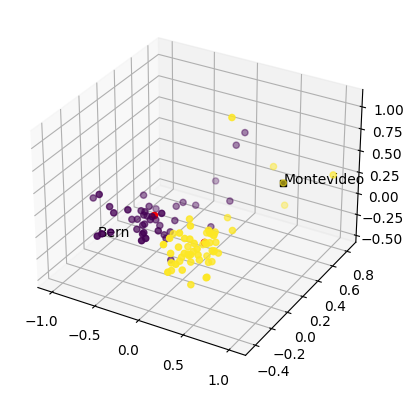

In [24]:
test.PCA_graph(df,original_df,dimensions=3,number_of_clusters=2)

Aquí se observa lo que la versión bidimensional no reflejaba tan claramente, o sea, la posibilidad de crear un cluster adicional a los 2 primeramente propuestos. Es indiscutible la robustez del algoritmo PCA, aunque también lo es que la pérdida de información siempre es relevante y vale la pena tenerla en cuenta a la hora de evaluar los resultados experimentales.

Se realiza nuevamente la visualización tridimensional ahora con 3 clusters para reafirmar lo antes comentado.

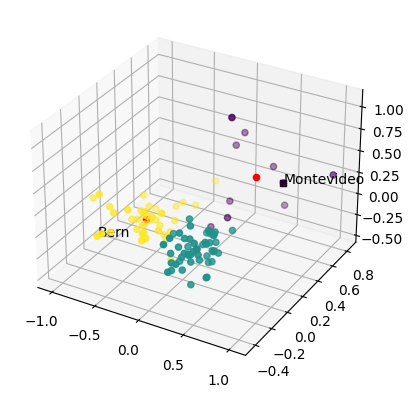

In [25]:
test.PCA_graph(df,original_df,dimensions=3,number_of_clusters=3)

## 4 Conclusiones

### 4.1 Resultados según expectativas iniciales

Desde un principio se consideró la posibilidad de que escalar los datos mostrara mejores resultados. Sin embargo, los datos obtenidos demuestran que no es fácil decir a simple vista si un método es mejor al otro dado que ambos trabajan con distintas escalas (afectando sus medidas con la norma euclídea) y podrían hasta haber hallado distintas relaciones entre los atributos.

Adicionalmente, se esperaba que la cantidad de clusters fuera mayor a la indicada como óptima tanto por el índice Silhouette como por el método del codo. Particularmente, usar solo 2 clusters parece contraintuitivo si se consideran la gran diversidad de países y variables que existen en el mundo. Resultados sin normalizar indican que 4 podría ser una opción también viable, aunque da lugar a la reflexión en cuanto a la cantidad de patrones que uno puede realmente encontrar.

En cuanto a la inicialización de clusters aleatoria, se esperaban peores resultados, aunque fue sorprendente la cantidad de veces que un cluster terminaba sin asignaciones al hacerlo de esta forma.

### 4.2 Momento en el que se dieron mejores resultados

En cuanto a datos escalados, es difícil dar un veredicto sobre la mejor variación. Los resultados escalados parecen concordar un poco más con los puntajes de Work-Life Balance aunque no parece ser motivo suficiente para ser mejor valorado, especialmente por la disparidad que sigue existiendo, sigue habiendo una gran mezcla de paises bien posicionados y mal posicionados respecto a Work-Life Balance en un mismo cluster.

Por otro lado, la mejor cantidad de grupos de acuerdo con el método del codo y Silhouette parece ser 2, y solo en base al primer método 3 o 4 podrían ser otros posibles valores óptimos. Visualmente, tanto el uso de 2 a 4 clusters parece razonable, pero dado que los 2 métodos de evaluación coinciden en favorecer al valor 2, se concluye que el óptimo consiste en 2 clusters. No obstante, dados los argumentos intuitivos antes mencionados, no se descarta el uso de 3 o 4. En particular, la visualización parecía favorecer a 3 (con datos normalizados) en contra de 4 (sin normalizar). 

En cuanto a la visualización de datos, no cabe duda que ver los datos de forma tridimensional fue fundamental para reconocer patrones no tan simples de ver. Sin el método del codo y silhouette, hubiera sido difícil intuir que 3 fuera un número óptimo de clusters con solo dos dimensiones.

### 4.3 Mejoras a futuro

Para tipos de trabajo experimentales siempre hay lugar para la mejora. En este trabajo en particular se consideraría más útil un mejor método para solucionar la existencia de clusters sin valores asignados durante la ejecución de kmeans, ya que el de la actual implementación puede realizar varias iteraciones hasta poder eliminar la existencia de clusters vacios.

Además de eso, sería útil una metaheurística que permita al algoritmo escapar de mínimos locales y solventar su sensibilidad a la inicialización de centroides. Específicamente, se puede utilizar una estrategia similar a la utilizada por sklearn, donde se ejecuta el algoritmo reiteradas veces, inicializando los clusters con distintos valores y tomando el mejor de todas las asignaciones.

Por otro lado, sería interesante probar con más combinaciones de atributos a eliminar y ver si esto afecta o no a los resultados.